<a href="https://colab.research.google.com/github/ayanban011/Getting-Started_with_Pytorch/blob/main/pre_trained_network_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Pre-trained models and transfer learning**

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called **transfer learning**, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as **ImageNet**. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [ ]:
#installing pytorchcv
#It is a very useful python snippet which implements a lots of function and dataloader, helps to reduce the effort of code writing
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2022-07-03 08:21:48--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s    in 0s      

2022-07-03 08:21:48 (91.0 MB/s) - ‘pytorchcv.py’ saved [6371/6371]



In [ ]:
!pip install torchinfo
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Cats vs. Dogs Dataset**

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats).
Let's download this dataset and extract it into `data` directory (this process may take some time!):

In [ ]:
#downloading the zip file of the dataset
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-07-03 08:31:11--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.164.176, 142.251.45.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   323MB/s    in 0.2s    

2022-07-03 08:31:11 (323 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
#Extracting the dataset
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Unfortunately, there are some corrupt image files in the dataset. We need to do quick cleaning to check for corrupted files. In order not to clobber this tutorial, we moved the code to verify dataset into a module, and we will just call it here. check_image_dir goes over the whole dataset image by image, tries to load the image and check if it can be loaded correctly. All corrupt images are deleted.

In [ ]:
%cd /tmp

/tmp


In [ ]:
!ls

cats_and_dogs_filtered
cats_and_dogs_filtered.zip
dap_multiplexer.4d5b7a5e7b7f.root.log.INFO.20220703-081201.56
dap_multiplexer.INFO
debugger_18t9xutsv6
initgoogle_syslog_dir.0
pyright-109-lc1LBHd52ulu
pyright-109-O0csZ9B1Ur7Z
pyright-153-7hN0pPgYpeEq
pyright-153-UYH7x0TFgWNH
python-languageserver-cancellation


In [ ]:
%cd cats_and_dogs_filtered

/tmp/cats_and_dogs_filtered


In [ ]:
!ls

train  validation  vectorize.py


In [ ]:
%cd train

/tmp/cats_and_dogs_filtered/train


In [ ]:
!ls

cats  dogs


In [ ]:
check_image_dir('/tmp/cats_and_dogs_filtered/train/cats/*.jpg')
check_image_dir('/tmp/cats_and_dogs_filtered/train/dogs*.jpg')

Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalization. We define image transformation pipeline by composing several primitive transformations using `Compose`:
* `Resize` resizes our image to 256x256 dimensions
* `CenterCrop` gets the central part of the image with size 224x224. Pre-trained VGG network has been trained on 224x224 images, thus we need to bring our dataset to this size.
* `ToTensor` normalizes pixel intensities to be in 0..1 range, and convert images to PyTorch tensors
* `std_normalize` transform is additional normalization step specific for VGG network. When training a VGG network, original images from ImageNet were transformed by subtracting dataset mean intensity by color and dividing by standard deviation (also by color). Thus, we need to apply the same transformation to our dataset, so that all images are processed correctly. 

There are a few reason why we resized images to size 256, and then cropped to 224 pixels:
* We wanted to demonstrate more possible transformations.
* Pets are usually somewhere in the central part of the image, so we can improve classification by focusing more on the central part
* Since some of the images are not square, we end up having padded parts of the image that do not contain any useful picture data, and cropping the image a bit reduces the padded part.

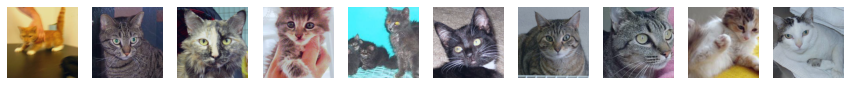

In [ ]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('/tmp/cats_and_dogs_filtered/train',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)

### **Pre-trained models**

There are many different pre-trained models available inside `torchvision` module, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used:

In [ ]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

tensor(282)


The result that we have received is a number of an ImageNet class, which can be looked up here. We can use the following code to automatically load this class table and return the result:

In [ ]:
import json, requests
class_map = json.loads(requests.get("https://mslearntensorflowlp.blob.core.windows.net/metadata/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

In [ ]:
#VGG16 architectures
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [ ]:
#GPU computations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(282, device='cuda:0')


### **Extracting VGG features**

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using `vgg.features` method:

torch.Size([1, 512, 7, 7])


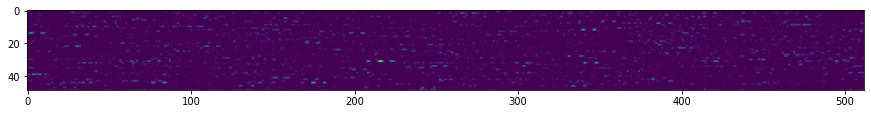

In [ ]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`

In [ ]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break

....................................................................................................

Now we can define `vgg_dataset` that takes data from this tensor, split it into training and test sets using `random_split` function, and train a small one-layer dense classifier network on top of extracted features:

In [ ]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  0, Train acc=0.910, Val acc=0.980, Train loss=0.046, Val loss=0.016
Epoch  1, Train acc=0.996, Val acc=0.990, Train loss=0.002, Val loss=0.019
Epoch  2, Train acc=0.997, Val acc=0.990, Train loss=0.001, Val loss=0.018
Epoch  3, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.015
Epoch  4, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.015
Epoch  5, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.015
Epoch  6, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.015
Epoch  7, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.015
Epoch  8, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.015
Epoch  9, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.015


### **Transfer learning using one VGG network**
We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training. Let's look at the VGG-16 object structure:

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
len(dataset)

2000

In [ ]:
trainset, testset = torch.utils.data.random_split(dataset,[1500,len(dataset)-1500])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.125, train loss = 0.07245943695306778
Epoch 0, minibatch 90: train acc = 0.9457417582417582, train loss = 0.11926436162256933
Epoch 0 done, validation acc = 0.962, validation loss = 0.1414356689453125


In [ ]:
#saving the weights
torch.save(vgg,'cats_dogs.pth')

In [ ]:
vgg = torch.load('cats_dogs.pth')

### **Fine-tuning transfer learning**

In the previous section, we have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor, and our model relied on the features that the model has learned on ImageNet data. If your objects visually differ from ordinary ImageNet images, this combination of features might not work best. Thus it makes sense to start training convolutional layers as well.

To do that, we can unfreeze the convolutional filter parameters that we have previously frozen. 

> **Note:** It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

In [ ]:
for x in vgg.features.parameters():
    x.requires_grad = True

After unfreezing, we can do a few more epochs of training. You can also select lower learning rate, in order to minimize the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than in the case of fixed weights.

> **Note:** This training happens much slower, because we need to propagate gradients back through many layers of the network! You may want to watch the first few minibatches to see the tendency, and then stop the computation.

In [ ]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

Epoch 0, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 0, minibatch 90: train acc = 0.9423076923076923, train loss = 0.048715874388977724
Epoch 0 done, validation acc = 0.964, validation loss = 0.013272058486938477


In [ ]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet.classifier = torch.nn.Linear(512,2).to(device)

for x in resnet.parameters():
    x.requires_grad = True

summary(resnet,(1, 3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 1,026
├─Conv2d: 1-1                            [1, 64, 32, 32]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 64, 16, 16]           --
│    └─BasicBlock: 2-1                   [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-3                    [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-4                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-6                    [1, 64, 16, 16]           -

In [ ]:
#GPU computations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

resnet.to(device)
sample_image = sample_image.to(device)

resnet(sample_image).argmax()

Doing computations on device = cuda


tensor(638, device='cuda:0')

In [ ]:
train_long(resnet,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

Epoch 0, minibatch 0: train acc = 0.0, train loss = 0.44024571776390076
Epoch 0, minibatch 90: train acc = 0.5824175824175825, train loss = 0.15905932541731949
Epoch 0 done, validation acc = 0.672, validation loss = 0.048371009826660157


### **Lightweight networks and MobileNet**


### **MobileNet**

Previously, we have seen **ResNet** architecture for image classification. More lightweight analog of ResNet is **MobileNet**, which uses so-called *Inverted Residual Blocks*. Let's load pre-trained mobilenet and see how it works:

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()
print(model)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
sample_image = dataset[0][0].unsqueeze(0)
res = model(sample_image)
print(res[0].argmax())

tensor(903)


In [ ]:
for x in model.parameters():
    x.requires_grad = False

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.classifier = nn.Linear(1280,2) #replacing the final classifier
model = model.to(device)
summary(model,input_size=(1,3,244,244))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV2                                   [1, 2]                    --
├─Sequential: 1-1                             [1, 1280, 8, 8]           --
│    └─ConvNormActivation: 2-1                [1, 32, 122, 122]         --
│    │    └─Conv2d: 3-1                       [1, 32, 122, 122]         (864)
│    │    └─BatchNorm2d: 3-2                  [1, 32, 122, 122]         (64)
│    │    └─ReLU6: 3-3                        [1, 32, 122, 122]         --
│    └─InvertedResidual: 2-2                  [1, 16, 122, 122]         --
│    │    └─Sequential: 3-4                   [1, 16, 122, 122]         (896)
│    └─InvertedResidual: 2-3                  [1, 24, 61, 61]           --
│    │    └─Sequential: 3-5                   [1, 24, 61, 61]           (5,136)
│    └─InvertedResidual: 2-4                  [1, 24, 61, 61]           --
│    │    └─Sequential: 3-6                   [1, 24, 61, 61]           (8,832)
│ 

In [ ]:
 train_long(model,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.4375, train loss = 0.045233264565467834
Epoch 0, minibatch 90: train acc = 0.8722527472527473, train loss = 0.026240469335199714
Epoch 0 done, validation acc = 0.964, validation loss = 0.007637086391448974
